# Federated Multi-channel VAEs in MNIST
In this notebook we illustrate a simple example of multi-channel data generated by rotating the MNIST dataset and modeling each angle of rotation as a data view/channel.

In [2]:
import torch
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

The set of parameters utilized in this tutorial can be configured as follows:

In [3]:
N_CENTERS = 4
N_ROUNDS = 10   # Number of iterations between all the centers training and the aggregation process.

N_EPOCHS = 15   # Number of epochs before aggregating
BATCH_SIZE = 48
LR = 1e-3       # Learning rate

N_CHANNELS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)

Device: cuda


To create the new channels, it is necessary to transform the dataset. A way to do it is to define a customized transform class that receives a set of angles (channels) and then apply it to the original image.

In [4]:
import torchvision.transforms.functional as TF

class MultiChannel:
    """Create a multi-channel version of each digit by rotating it"""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        return [TF.rotate(x, angle) for angle in self.angles]

In [5]:
angles = torch.linspace(0, 300, N_CHANNELS).tolist()  # Number of rotations to generate (channels in the range 0-300 deg)
transform = transforms.Compose([
            transforms.ToTensor(),
            MultiChannel(angles)
])

In [6]:
dataset = datasets.MNIST('~/data/', download=True, train=True, transform=transform)

We can then visualize the results of the transformation for a couple of observations.

In [7]:
def plot_digit(mnist_point, angles=None):
    images, label = mnist_point

    fig, axs = plt.subplots(ncols=len(images), subplot_kw={'xticks': [], 'yticks': []})
    for ax, image in zip(axs, images):
        ax.imshow(image.reshape(28,28), cmap='gray')

    if angles is not None:
        for ax, angle in zip(axs, angles):
            ax.set_title(f'{angle}$^\circ$')
    
    plt.suptitle(f'Label: {label}', size=24, weight='bold')
    plt.tight_layout()
    return ax

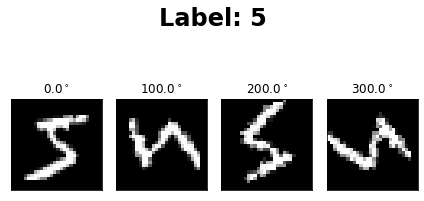

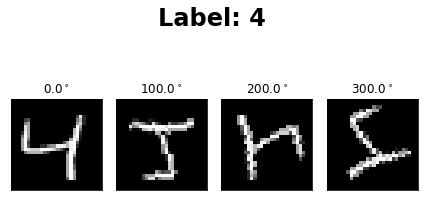

In [8]:
plot_digit(dataset[0], angles)
plot_digit(dataset[2], angles)
plt.show()

## Federated Averaging using iid splitting

In [9]:
def split_iid(dataset, n_centers):
    """ Split PyTorch dataset randomly into n_centers """
    n_obs_per_center = [len(dataset) // n_centers for _ in range(n_centers)]
    return random_split(dataset, n_obs_per_center)

In [10]:
def federated_averaging(models, n_obs_per_client):
    assert len(models) > 0, 'An empty list of models was passed.'
    assert len(n_obs_per_client) == len(models), 'List with number of observations must have ' \
                                                 'the same number of elements that list of models.'

    # Compute proportions
    n_obs = sum(n_obs_per_client)
    proportions = [n_k / n_obs for n_k in n_obs_per_client]

    # Empty model parameter dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params.keys():
            avg_params[key] += proportion * model.state_dict()[key]

    # Copy one of the models and load trained params
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)

    return avg_model

In [11]:
federated_dataset = split_iid(dataset, n_centers=N_CENTERS)
print('Number of centers:', len(federated_dataset))

Number of centers: 4


## Defining and distributing a model: Multi-channel Variational Autoencoder
In this excercise we will use the Multi-channel Variational Autoencoder proposed by Antelmi _et_ al.

In [12]:
!pip install -q git+https://gitlab.inria.fr/epione_ML/mcvae.git

In [13]:
import copy
from mcvae.models import Mcvae, ThreeLayersVAE, VAE

                                           uuid  ... memory.total
index                                            ...             
0      GPU-15b8e8d9-4cfc-b229-ed4c-a9c8fdd3adc9  ...        11441

[1 rows x 6 columns]


Then we define a set of parameters necessary to instantiate the model.

In [14]:
N_FEATURES = 784  # Number of pixels in MNIST

In [15]:
dummy_data = [torch.zeros(1, N_FEATURES) for _ in range(N_CHANNELS)]  # Dummy data to initialize the input layer size
lat_dim = 3  # Size of the latent space for this autoencoder
vae_class = ThreeLayersVAE  # Architecture of the autoencoder (VAE: Single layer)

A model is then defined and then send (copied) to the clients for training on their available data.

In [16]:
model = Mcvae(data=dummy_data, lat_dim=lat_dim, vaeclass=vae_class).to(DEVICE)
model.optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
model.init_loss()

Now replicate a copy of the models across different centers.

In [17]:
models = [copy.deepcopy(model) for _ in range(N_CENTERS)]
n_obs_per_client = [len(client_data) for client_data in federated_dataset]

Train in a federated fashion

In [18]:
def get_data(subset, shuffle=True):
    """ Extracts data from a Subset torch dataset in the form of a tensor"""
    loader = DataLoader(subset, batch_size=len(subset), shuffle=shuffle)
    return iter(loader).next()

In [19]:
init_params = model.state_dict()
for round_i in range(N_ROUNDS):
    print(f'=============================== ROUND {round_i + 1} ===============================')
    for client_dataset, client_model in zip(federated_dataset, models):
        # Load client data in the form of a tensor
        X, y = get_data(client_dataset)
        X = [x.view(-1, N_FEATURES).to(DEVICE) for x in X]  # Flatten for Linear layers
        client_model.data = X

        # Load client's model parameters and train
        client_model.load_state_dict(init_params)
        client_model.optimize(epochs=N_EPOCHS, data=client_model.data)
        
    # Aggregate models using federated averaging
    trained_model = federated_averaging(models, n_obs_per_client)
    init_params = trained_model.state_dict()

=============================== ROUND 1 ===============================
====> Epoch:    0/15 (0%)	Loss: 8461.6523	LL: -8461.6309	KL: 0.0211	LL/KL: -400548.4064
====> Epoch:   10/15 (67%)	Loss: 1105.4454	LL: -1083.1682	KL: 22.2773	LL/KL: -48.6221
====> Epoch:    0/15 (0%)	Loss: 8462.0410	LL: -8462.0195	KL: 0.0211	LL/KL: -401301.4389
====> Epoch:   10/15 (67%)	Loss: 1113.8654	LL: -1091.7914	KL: 22.0739	LL/KL: -49.4606
====> Epoch:    0/15 (0%)	Loss: 8522.7480	LL: -8522.7266	KL: 0.0211	LL/KL: -404286.2857
====> Epoch:   10/15 (67%)	Loss: 1139.8148	LL: -1117.2366	KL: 22.5782	LL/KL: -49.4829
====> Epoch:    0/15 (0%)	Loss: 8539.5166	LL: -8539.4951	KL: 0.0211	LL/KL: -404330.8462
====> Epoch:   10/15 (67%)	Loss: 1144.1252	LL: -1121.5454	KL: 22.5799	LL/KL: -49.6702
=============================== ROUND 2 ===============================
====> Epoch:   20/30 (67%)	Loss: 673.3018	LL: -594.1547	KL: 79.1472	LL/KL: -7.5070
====> Epoch:   20/30 (67%)	Loss: 682.7709	LL: -603.8767	KL: 78.8942	LL/KL: -7

## Results visualization
Using the final parameters we can evaluate the performance of the model by visualizing the testing set onto the latent space. In the Multi-channel scenario, the latent variables $i$ in the latent space of the channel $j$ is defined as $Z_{ij}$.

In [20]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [21]:
dataset_test = datasets.MNIST('~/data/', train=False, download=True, transform=transform)
X_test, y_test = get_data(dataset_test)
X_test = [x.view(-1, N_FEATURES).to(DEVICE) for x in X_test]  # Flatten for Linear layers

In [22]:
Z_test = np.hstack([z.loc.cpu().detach().numpy() for z in trained_model.encode(X_test)])

In [23]:
col_names = [f'$Z_{{{(i // lat_dim) + 1}{(i % lat_dim) + 1}}}$' for i in range(Z_test.shape[1])]
latent_df = pd.DataFrame(Z_test, columns=col_names)
latent_df['label'] = y_test
latent_df['label'] = latent_df['label'].astype('category')
latent_df.head()

,$Z_{11}$,$Z_{12}$,$Z_{13}$,$Z_{21}$,$Z_{22}$,$Z_{23}$,$Z_{31}$,$Z_{32}$,$Z_{33}$,$Z_{41}$,$Z_{42}$,$Z_{43}$,label
0,-1.836733,-0.541675,2.626518,-1.834759,-0.427387,2.642610,-1.892036,-0.469842,2.679921,-1.833463,-0.503372,2.641706,5
1,-0.052134,-0.643257,2.186315,0.026131,-0.627934,2.161103,0.003671,-0.775653,2.187668,-0.072231,-0.613178,2.200200,9
2,0.295430,-0.565104,0.808192,0.297953,-0.577041,0.845502,0.339431,-0.616785,0.818862,0.314601,-0.576570,0.782091,2
3,0.292785,-0.775920,1.084410,0.530444,-0.809846,1.136328,0.477896,-0.708132,1.191237,0.295386,-0.821254,1.176053,6
4,1.955340,3.049021,1.573791,2.166283,3.061774,1.487722,2.132793,3.041331,1.513418,2.023544,3.144786,1.534572,0


### Representation of the test set onto the latent space

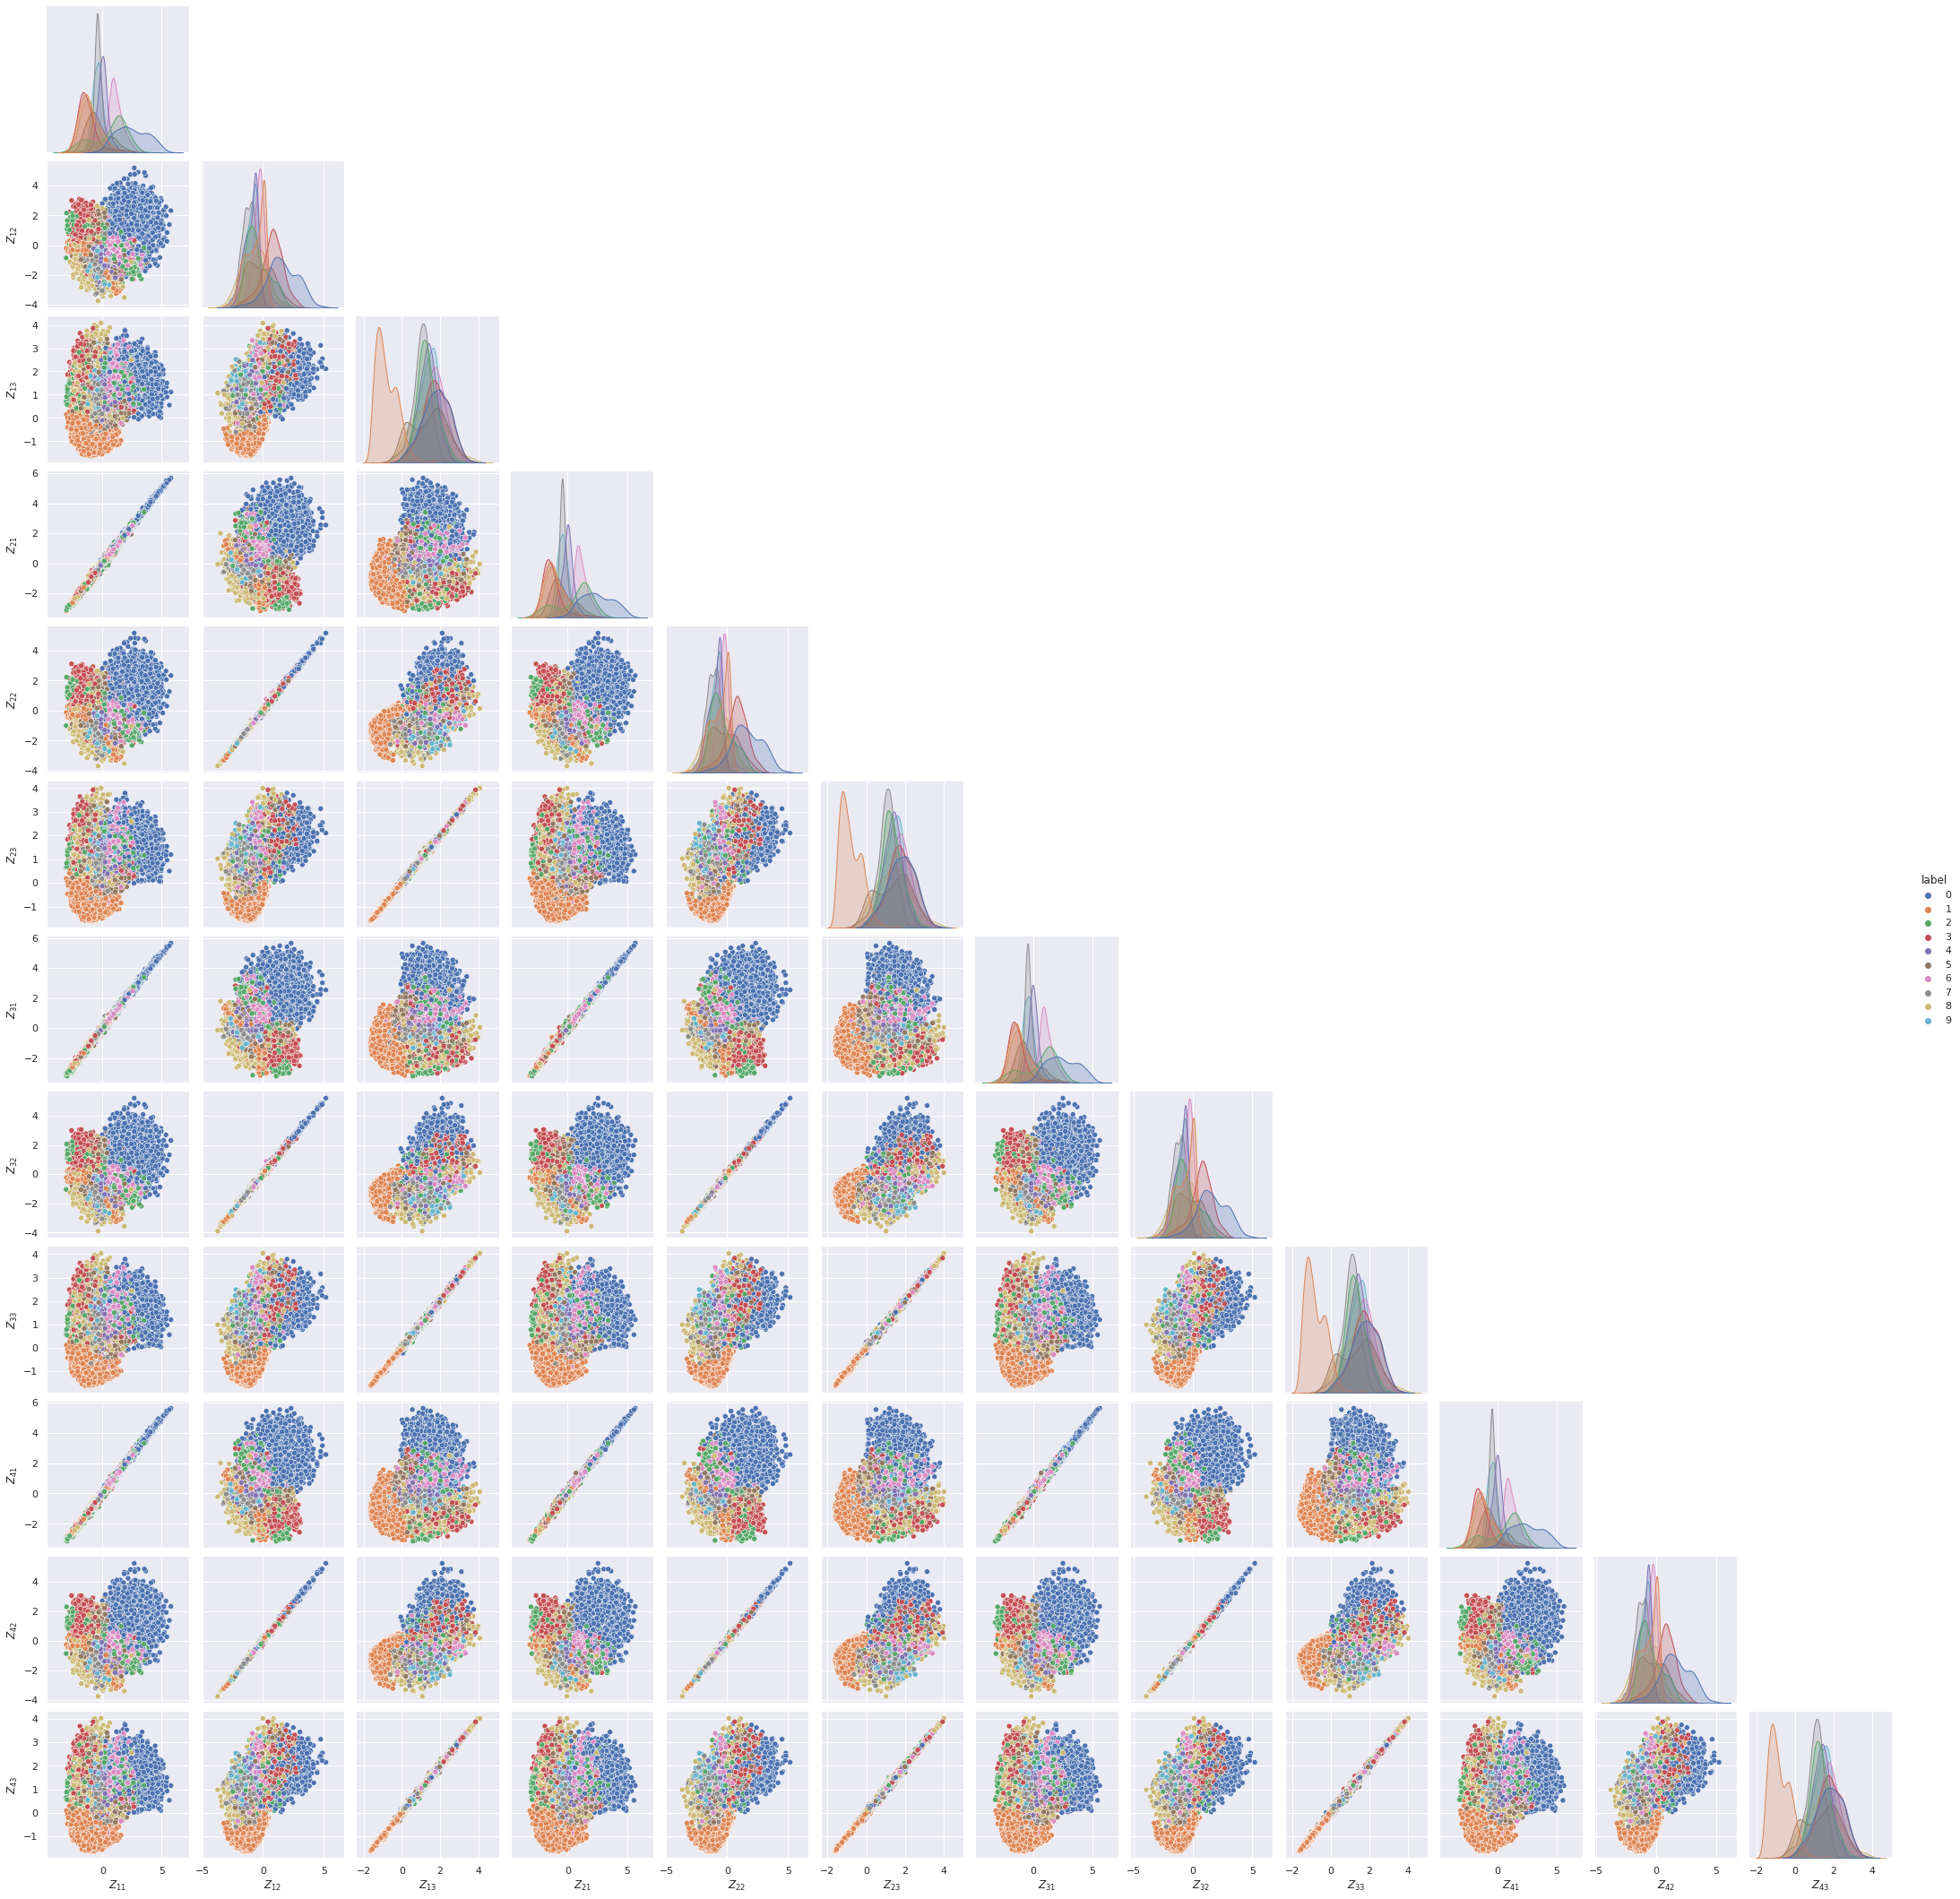

In [24]:
sns.pairplot(latent_df, hue='label', corner=True)
plt.show()

## Evualuation of the reconstruction
Another way to evaluate the performance of this model is to evaluate the reconstruction.

In [40]:
sample_test = [x.reshape(-1, N_FEATURES) for x in dataset_test[0][0]]
sample_pred = trained_model.reconstruct(sample_test)
sample_pred = [x.reshape(-1, 28, 28) for x in sample_test]

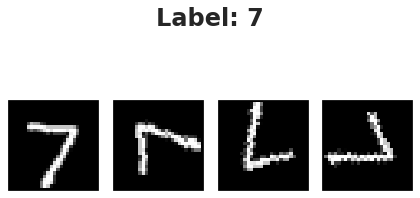

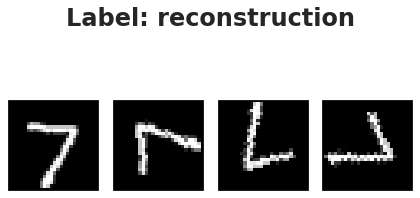

In [51]:
plot_digit(dataset_test[0])
plot_digit((sample_test, "reconstruction"))
plt.show()

As observed, the reconstruction is quite good in all the views.

## Generation of new datapoints
We can try to generate random digits and their respective rotations in a random manner:

First, by definition the aim is to capture all the relationships in the data in the latent space contrained as a Normal distribution $Z \sim \mathcal{N}(0,1)$. So we can take a sample and reconstruct from there new digits.

In [188]:
from torch.distributions import Normal

In [193]:
rsample = Normal(torch.zeros(1, lat_dim), torch.ones(1, lat_dim)).sample().to(DEVICE)
z_rsample = [rsample for _ in range(N_CHANNELS)]

In [194]:
# Reconstruction process.
# Taken from: https://gitlab.inria.fr/epione_ML/mcvae/-/blob/master/src/mcvae/models/mcvae.py#L162
p = trained_model.decode_in_reconstruction(z_rsample)
x_hat = []
for c in range(N_CHANNELS):
    if c in trained_model.dec_channels:
        # mean along the stacking direction
        x_tmp = torch.stack([p[c][e].loc.detach() for e in range(N_CHANNELS)]).mean(0)
        x_hat.append(x_tmp)
        del x_tmp
    else:
        x_hat.append(None)

In [195]:
generated_sample = [x.reshape(-1, 28, 28).detach().cpu() for x in x_hat]

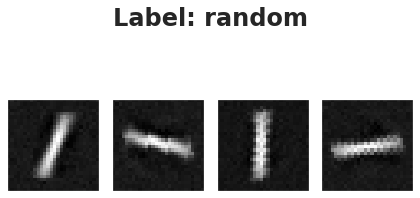

In [196]:
plot_digit((generated_sample, "random"))
plt.show()